# Libraries used to get pretrained ViT

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from implemented_functions_to_use.helper_functions import set_seeds
from PIL import Image
import os

C:\Users\YOGA\.conda\envs\TF1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Testing which device used to train (CPU or GPU) 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Save parameters as class

In [3]:
# Configure Model Parameters
class PARAM:
    EPOCHS = 10
    BATCH_SIZE = 32
    P = 0.5 #probability for Data Augmentation
    TF_SEED = 768
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_MEAN = [0.456]     #for Data Augmentation
    IMAGE_STD_DEVIATION = [0.224]     #for Data Augmentation
    PROB = 0.5
    WEIGHT_DECAY = 0.01

# get pretraind model with his weight from torch

In [4]:
# Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT 

# create a ViT model with pretrained weights
model_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Disable Gradient
for parameter in model_vit.parameters():
    parameter.requires_grad = False
    
# Define the classifier head 
class_names = ['Astrocitoma T1','Meningioma T1','Neurocitoma T1','Papiloma T1','Schwannoma T1','NORMAL T1']

set_seeds()
model_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)


In [5]:
from torchinfo import summary

# Print a summary using torchinfo 
summary(model=model_vit, 
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 6]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [6]:
# Setup directory paths to train and test images
train_dir = './archive_for_multiple_classes/train'
test_dir = './archive_for_multiple_classes/val'

## Turning images into DataLoaders using the create_dataloaders()

In [7]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

### DATA Augmentation testing

In [8]:
# Get automatic transforms from pretrained Swin weights
model_vit_transforms = pretrained_vit_weights.transforms(mean=PARAM.IMAGE_MEAN, std=PARAM.IMAGE_STD_DEVIATION)

pre_train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=PARAM.PROB),            # Random horizontal flip
    transforms.RandomRotation(degrees=15),              # Random rotation
])

train_transform = transforms.Compose([
    model_vit_transforms,
    pre_train_transform
])

val_transform = model_vit_transforms

print(model_vit_transforms)
print(pre_train_transform)
print(train_transform)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.456]
    std=[0.224]
    interpolation=InterpolationMode.BILINEAR
)
Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
)
Compose(
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.456]
    std=[0.224]
    interpolation=InterpolationMode.BILINEAR
)
    Compose(
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-15.0, 15.0], interpolation=nearest, expand=False, fill=0)
)
)


## TESTING TRANSFORMER (Data AUG)

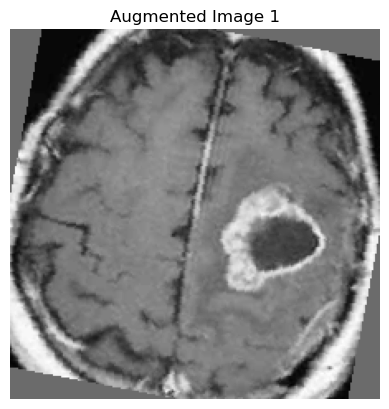

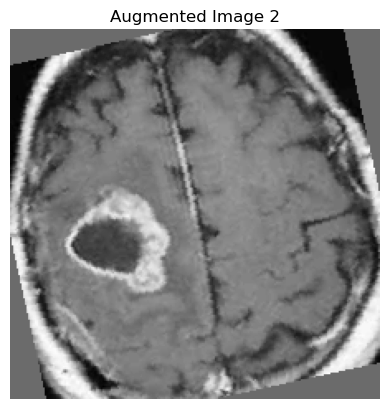

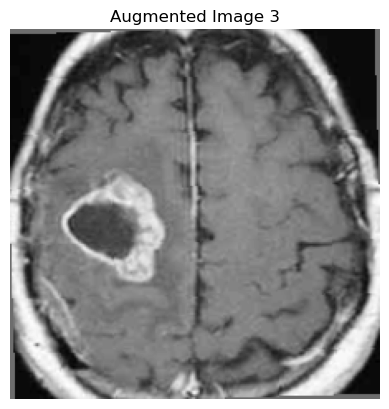

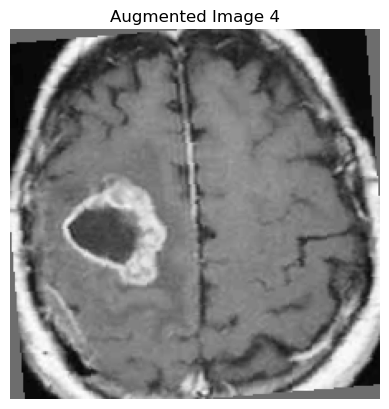

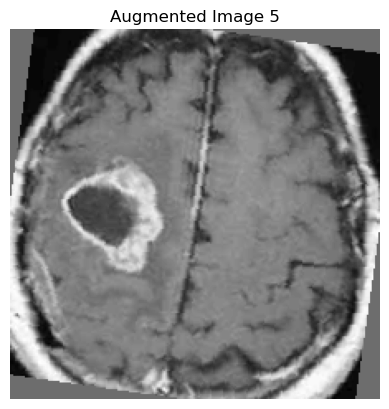

In [9]:
test_train_img = './archive_for_2_classes/train/yes/Y102.jpg'
image = Image.open(test_train_img)

def show_image(tensor, title="Test DA"):
    image = tensor.permute(1, 2, 0) # Convert from C x H x W to H x W x C for plotting
    plt.imshow(image, cmap="gray")
    plt.title(title)
    plt.axis('off')
    plt.show()

for i in range(5):  
    augmented_image = train_transform(image)
    show_image(augmented_image, title=f"Augmented Image {i+1}")

## Data augmenting Images

In [10]:
# Function to check if a folder has less than 200 images and augment if necessary
def augment_folder(folder_path: str, num_images_required: int = 200):
    current_images = os.listdir(folder_path)
    num_images = len(current_images)
    
    if num_images < num_images_required:
        print(f"Folder {folder_path} has {num_images} images. Augmenting...")
        
        augment_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            # transforms.RandomRotation(degrees=45),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
            transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))
        ])

        while num_images < num_images_required:
            image_to_augment = random.choice(current_images)
            image_path = os.path.join(folder_path, image_to_augment)
            image = Image.open(image_path)
            
            augmented_image = augment_transform(image)
            new_image_name = f"aug_{num_images}.jpg"
            augmented_image.save(os.path.join(folder_path, new_image_name))
            num_images += 1
        print(f"Folder {folder_path} now has {num_images} images.")

def augment_dataset_folder(root_dir: str, num_images_required: int = 200):
    for class_folder in os.listdir(root_dir):
        class_folder_path = os.path.join(root_dir, class_folder)
        if os.path.isdir(class_folder_path):
            augment_folder(class_folder_path, num_images_required)

## Turning images into DataLoaders using the create_dataloaders()

In [11]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    train_transform: train_transform,
    val_transform: val_transform,
    batch_size: int, 
    num_workers: int=NUM_WORKERS,
    augment: bool=True
):
    # Augmenting images of class directories which is less than 200 images 
    if augment:
        augment_dataset_folder(train_dir)
        augment_dataset_folder(test_dir,int(50))
    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    test_data = datasets.ImageFolder(test_dir, transform=val_transform)
    
    
    class_names = train_data.classes
    
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )
    
    return train_dataloader, test_dataloader, class_names

In [12]:
train_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=train_dir,
                                                                                     test_dir=test_dir,
                                                                                     train_transform=train_transform,
                                                                                     val_transform=val_transform,
                                                                                     batch_size=PARAM.BATCH_SIZE) 

## Traing model and save results as dictionary

In [16]:
from implemented_functions_to_use.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=model_vit.parameters(), 
                             lr=1e-3,
                             weight_decay=PARAM.WEIGHT_DECAY # To reduce the risk of overfitting
                            )
loss_fn = torch.nn.CrossEntropyLoss()

set_seeds()
model_vit_results = engine.train(model=model_vit,
                                      train_dataloader=train_dataloader,
                                      test_dataloader=test_dataloader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=PARAM.EPOCHS,
                                      device=device)

  0%|          | 0/10 [05:33<?, ?it/s]


KeyboardInterrupt: 

## Save model results as file

In [14]:
import pickle

# Saving the model
with open('model_vit_results.pkl', 'wb') as file:
    pickle.dump(model_vit_results, file)

print("Model saved successfully!")


Model saved successfully!


# Save model 

In [15]:
import pickle

# Saving the model
with open('model_vit.pkl', 'wb') as file:
    pickle.dump(model_vit, file)

print("Model saved successfully!")


Model saved successfully!


## Load model files

In [7]:
import pickle
# Loading the model
# with open('model_vit_results.pkl', 'rb') as file:
with open('C:/Users/YOGA/Desktop/DM IMGs/model_vit_results.pkl', 'rb') as file:
    model_vit_results = pickle.load(file)

print("Loaded vit_model_results:", model_vit_results)


Loaded vit_model_results: {'train_loss': [1.2342840641736985, 0.7991133466362953, 0.639399566501379, 0.5532684065401554, 0.49496357664465906, 0.43653196170926095, 0.3975990030914545, 0.3666020050644875, 0.34695109762251375, 0.3345854073762894, 0.31576764956116676, 0.2880912829190493, 0.2805165499448776, 0.2690916433930397, 0.26004695035517217, 0.24825307168066502, 0.23563886862248182, 0.22306269481778146, 0.22014426812529564, 0.2187556501477957, 0.20093321539461612, 0.20320335850119592, 0.20381162986159324, 0.19579823035746813, 0.19895584508776665, 0.1905703641474247, 0.18837742116302253, 0.17716048788279296, 0.18332449458539485, 0.18060369566082954], 'train_acc': [0.57615625, 0.7674375, 0.81275, 0.83675, 0.8614062499999999, 0.8909687500000001, 0.903125, 0.9021250000000001, 0.9116250000000001, 0.91753125, 0.91596875, 0.93103125, 0.93159375, 0.94765625, 0.9417500000000001, 0.94721875, 0.94453125, 0.9529062500000001, 0.9568125000000001, 0.9546875, 0.9609375, 0.9599375, 0.9602812500000001

In [15]:
# Loading the model
with open('model_vit.pkl', 'rb') as file:
    model_vit = pickle.load(file)

print("Loaded vit_model:", model_vit)


Loaded vit_model: VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate=none)
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)

In [8]:
# print model training and testing accuarcy 
print('Train accuracy:',model_vit_results["train_acc"][-1],'. Test accuracy:', model_vit_results["test_acc"][-1])

Train accuracy: 0.9661875 . Test accuracy: 0.7135416666666667


c:\Users\YOGA\.conda\envs\TF1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


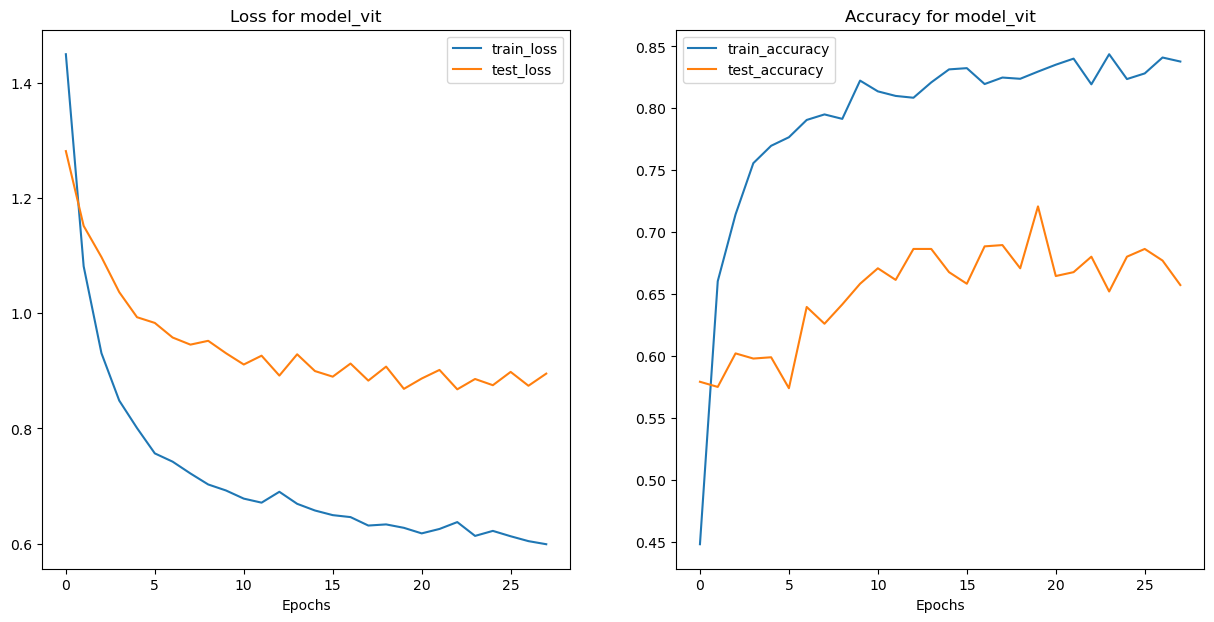

In [2]:
# Plot the loss curves
from implemented_functions_to_use.helper_functions import plot_loss_curves,plot_roc_auc,plot_confusion_matrix
# Plot loss curve
plot_loss_curves('model_vit',model_vit_results)



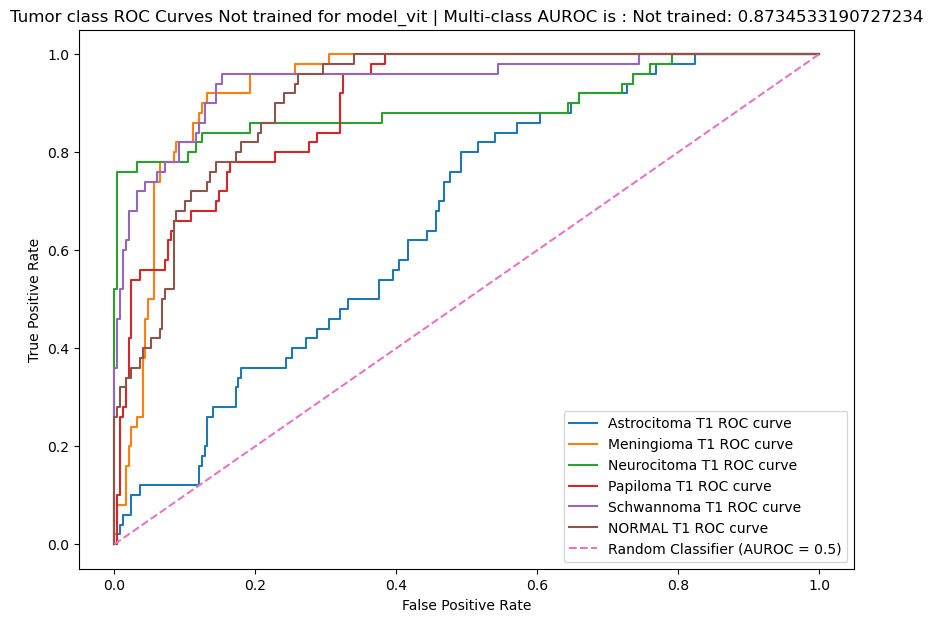

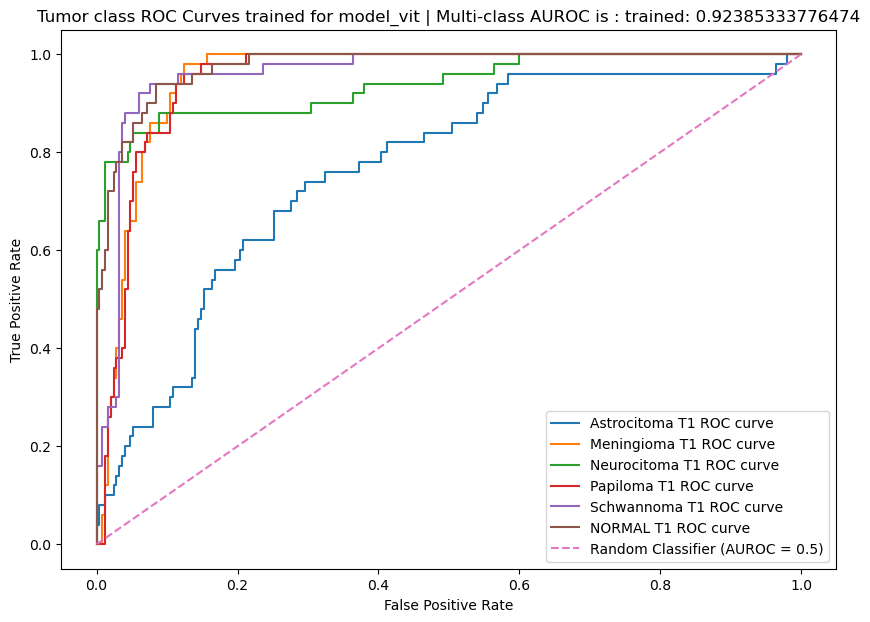

In [3]:
# Plot roc auc
class_names = ['Astrocitoma T1','Meningioma T1','Neurocitoma T1','Papiloma T1','Schwannoma T1','NORMAL T1']
plot_roc_auc('model_vit',model_vit_results,len(class_names),class_names,False)
plot_roc_auc('model_vit',model_vit_results,len(class_names),class_names,True)


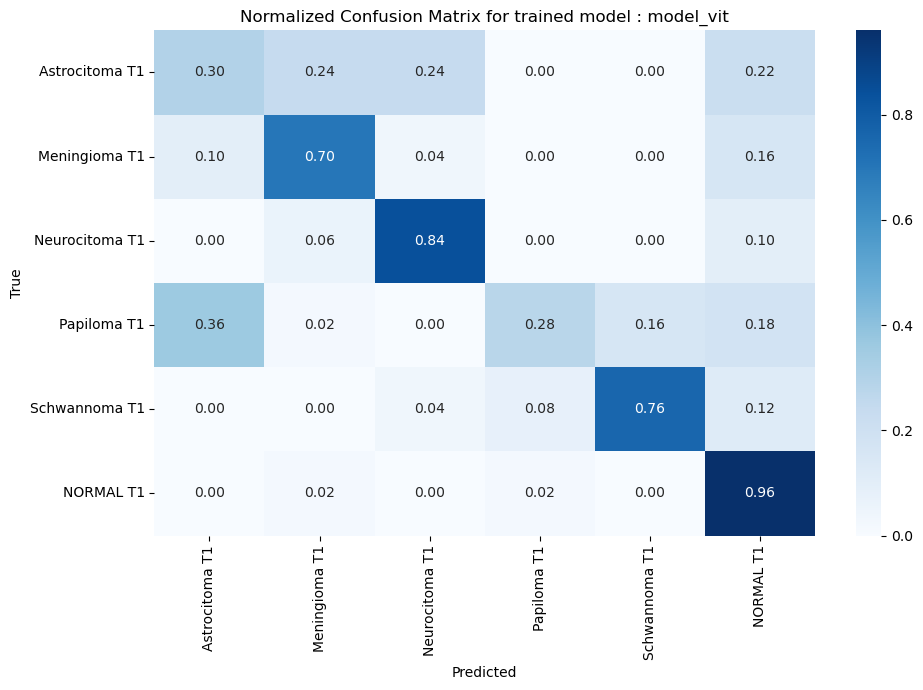

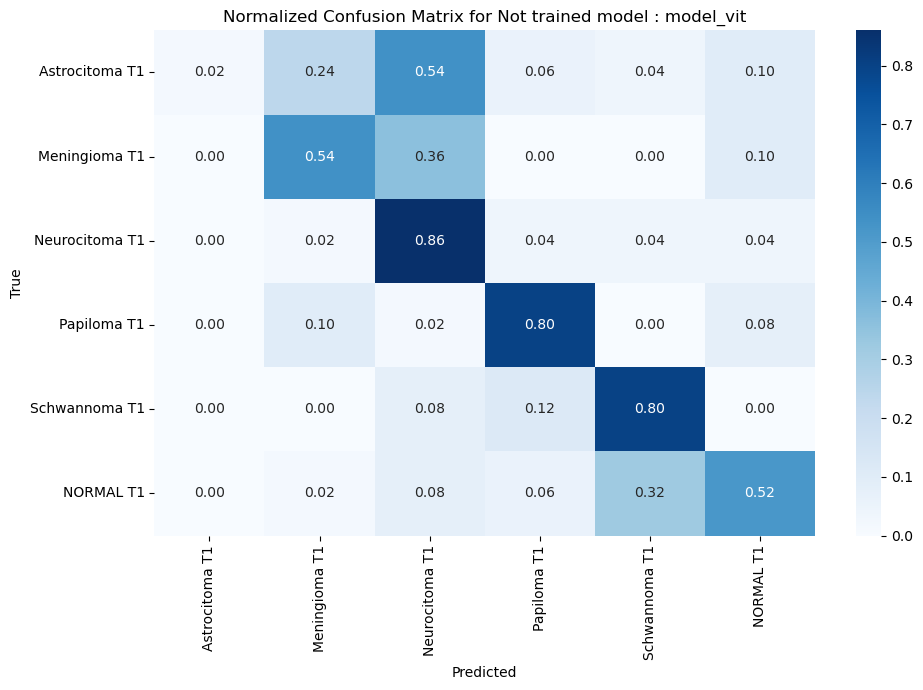

In [4]:
# plot confusion matrix
plot_confusion_matrix('model_vit',model_vit_results,class_names,True)
plot_confusion_matrix('model_vit',model_vit_results,class_names,False)

# Making some Predictions:

### Predict all images within predict folder

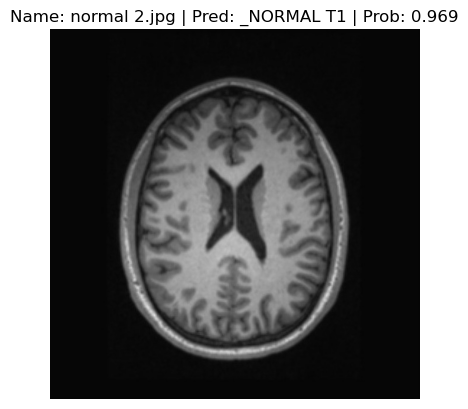

In [19]:
import requests

# Import function to make predictions on images and plot them 
from implemented_functions_to_use.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "./predict/normal 2.jpg"

# Predict on custom image
pred_and_plot_image(model=model_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

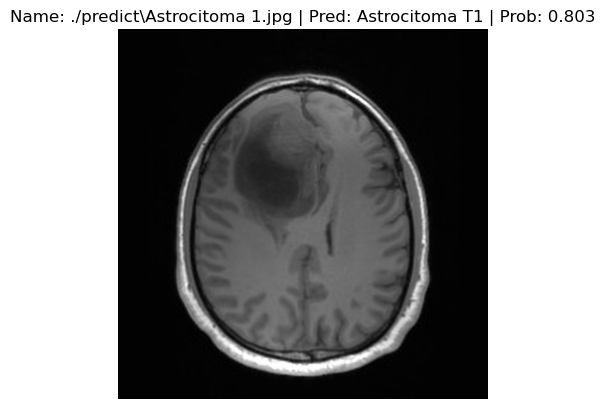

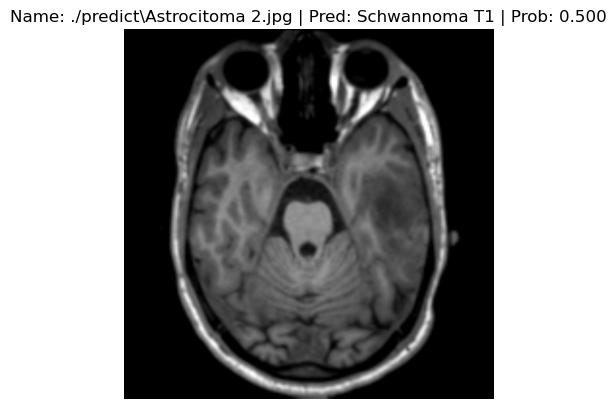

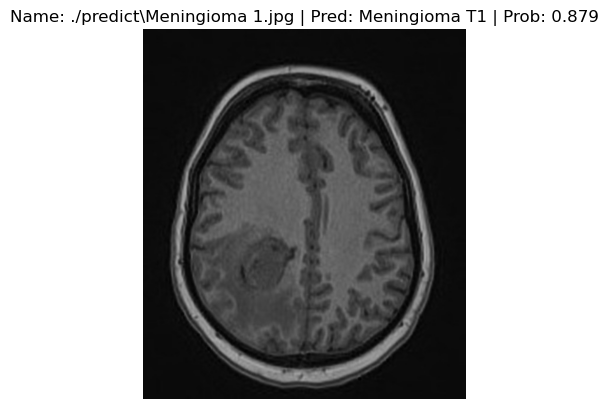

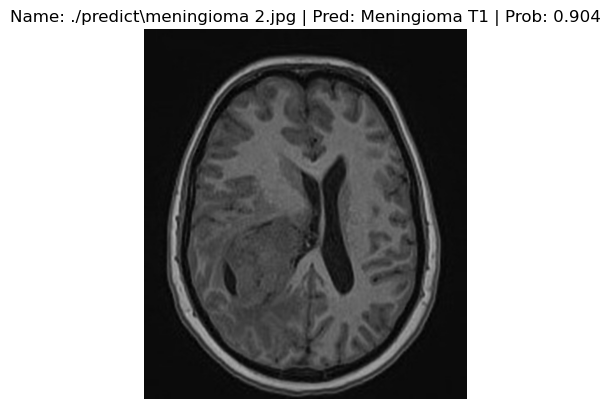

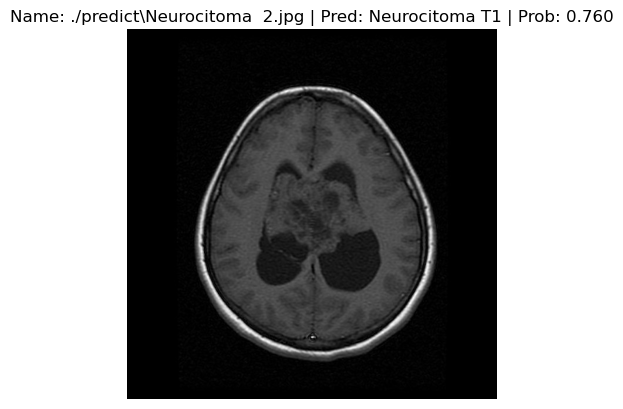

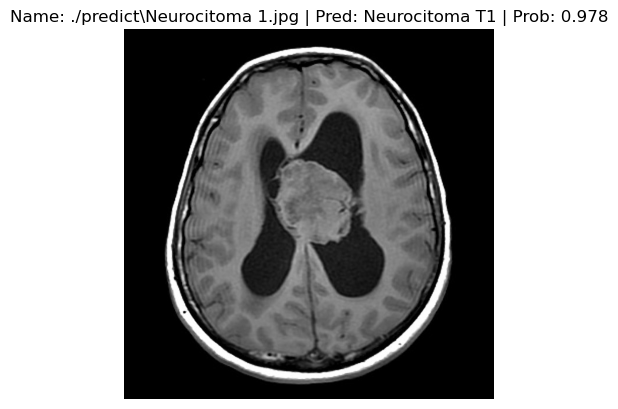

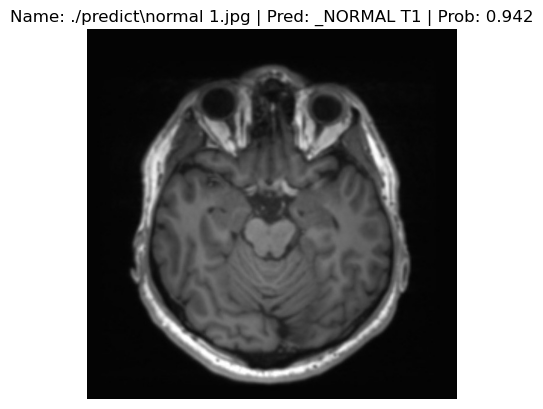

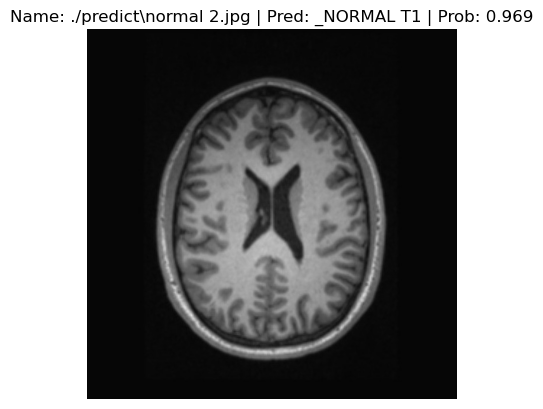

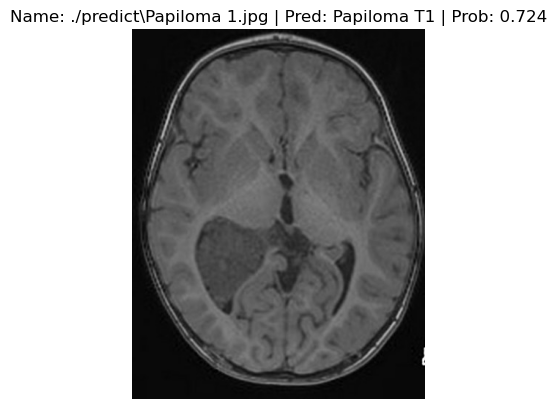

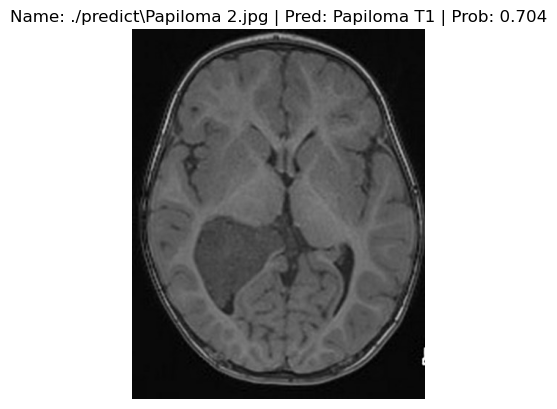

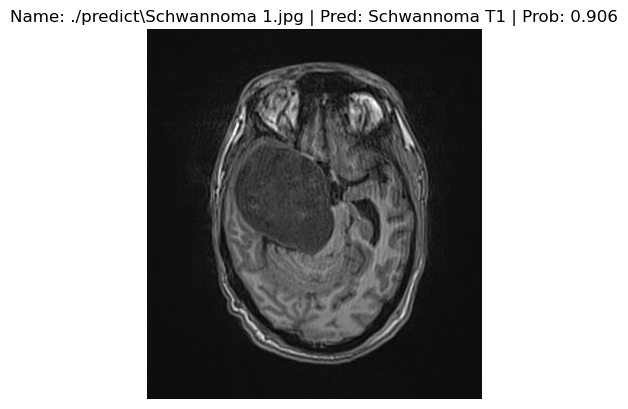

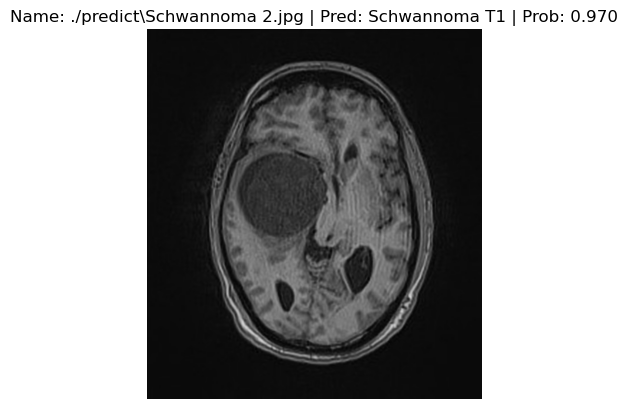

In [20]:
import glob
from implemented_functions_to_use.going_modular.predictions import pred_and_plot_image
predict_path = './predict/*.jpg'
for image_path in glob.iglob(predict_path):
    pred_and_plot_image(model=model_vit,
                    image_path=image_path,
                    class_names=class_names)
    


In [21]:
import requests

# Import function to make predictions on images and plot them 
from implemented_functions_to_use.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "./predict/normal 2.jpg"

# Predict on custom image
pred_and_plot_image(model=model_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

NameError: name 'loaded_model' is not defined